## Import

In [1]:
import random
import scipy.stats as stats
import scipy
from river import stats
import numpy as np
import matplotlib.pyplot as plt
from river import sketch
from scipy.stats import ksone

## KS part

In [2]:
def ks_quantile(quantile_list, river_histogram, N):
    
    # Initialize the ks
    ks = 0
    
    quantile_length = len(quantile_list) + 2 # + 2 for Q0 and Q1
    
    for i, quantile in enumerate(quantile_list, start=1):
        x = quantile.get()
        
        i_j = int(N*i/quantile_length)
        
        E_x = np.abs(i_j/N - river_histogram.cdf(x)) #The Paper formula
        #E_x = np.maximum(river_histogram.cdf(x) - ((i_j-1)/N), i_j/N - river_histogram.cdf(x)) #The real Kolmogorov-Smirnov test formula
        ks = np.maximum(ks, E_x)
           

    return ks

In [3]:
def define_ks_quantile(quantile_list):

    num_quantiles = 30 #More quantiles we have, the more we have precise results

    for i in range(1, num_quantiles):
        quantile_list.append(stats.Quantile(i/num_quantiles))
    return quantile_list

In [4]:
def update_ks_quantile(x, quantile_list):
    for quantile in quantile_list:
        quantile.update(x)

In [37]:
def methode2(x, hist, N, K, histogram_exp):
    
    D_hat = 0
    nb_tot = np.sum([hist[i].count for i in range (len(hist))])

    for p in range(len(hist)):
        proba=np.sum([hist[i].count for i in range (p+1)])/nb_tot
        proba_exp=np.sum([histogram_exp[i].count for i in range (p+1)])/nb_tot
        E_hat=np.abs(proba_exp-proba)
        D_hat=D_hat if D_hat > E_hat else E_hat
        
    return D_hat

## Benchmark

In [39]:
N = 1000
X = [random.uniform(0, 1) for _ in range(N)]
X_exp_uniform = [random.uniform(0, 1000) for _ in range(N)]#for methode2
K = 30
c = 1

#X = np.random.normal(0, 1, N)
#c = 3

#The Distribution to compare to, here a uniform distrib
cdf = [random.uniform(0, 1) for _ in range(N)]


#We know in advance the distribution to compare to, so we can make a sketch of it
river_histogram = sketch.Histogram(max_bins=K)
histogram_exp = sketch.Histogram(max_bins=K) #for methode2

for i, x in enumerate(cdf):
    river_histogram.update(x)
    histogram_exp.update(X_exp_uniform[i-1])

    


quantile_list = []
quantile_list = define_ks_quantile(quantile_list)

ks_results = {
    'scipy': [],
    'critical': [],
    'ks_quantile': [],
    'methode2':[]}

for i, x in enumerate(X, start=1):
    river_histogram.update(x)
    
    histogram_exp.update(X_exp_uniform[i-1])
     
    update_ks_quantile(x, quantile_list)
    
   
    ks_results['scipy'].append(scipy.stats.kstest(X[:i], cdf)[0])
    ks_results['critical'].append(ksone.ppf(1-0.005, i))
    ks_results['ks_quantile'].append(ks_quantile(quantile_list, river_histogram, i))
    ks_results['methode2'].append(methode2(x, river_histogram, N, K, histogram_exp))

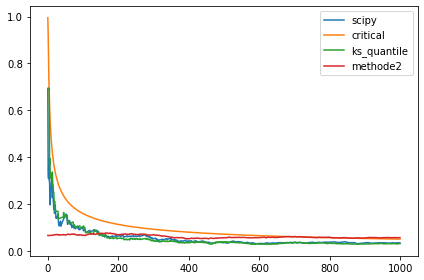

In [40]:
fig, ax = plt.subplots()


ax.plot(ks_results['scipy'], label='scipy')
ax.plot(ks_results['critical'], label='critical')
ax.plot(ks_results['ks_quantile'], label='ks_quantile')
ax.plot(ks_results['methode2'], label='methode2')

ax.legend()

fig.tight_layout()